In [1]:
%matplotlib widget
import testgear
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.dates as mdates
import glob
import ipywidgets as widgets
import datetime
import time
import matplotlib

In [2]:
F732C = 9.9999726 #18:00

In [3]:
files = sorted(glob.glob("data/*_F732C_M69.xlsx"))

bar = widgets.IntProgress(
    value=0,
    min=0,
    max=len(files),
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'blue'},
    orientation='horizontal'
)

bar

IntProgress(value=0, description='Loading:', max=761, style=ProgressStyle(bar_color='blue'))

In [4]:
times  = []
values = []
stds   = []
temperature = []

for filename in files:
    bar.value +=1
    print(filename, end = "\r")
    data = pd.read_excel(filename)
    
    times.append(np.mean(data["timestamp"]))
    values.append(np.mean(data["diff"]*1e6))
    stds.append( 2 * np.std(data["diff"]*1e6)/len(data["diff"])**0.5  )
    #stds.append( np.std(data["diff"]*1e6) )
    temperature.append(np.mean(data["temp"]))

values = np.array(values)

In [5]:
ts = np.array([ (float(x.to_datetime64()) - float(times[0].to_datetime64())) * 1e-9 for x in times])

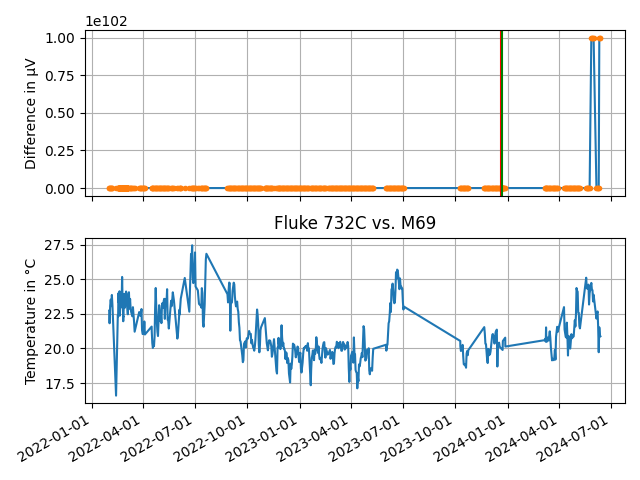

In [6]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.title("Fluke 732C vs. M69")

#ax[0].errorbar(times, values, yerr=stds, capsize=5)
ax[0].plot(times, values)
ax[0].plot(times, values, '.')
ax[0].set_ylabel("Difference in µV")
ax[0].axvline(datetime.datetime.strptime('2023-12-20 18:38:00', '%Y-%m-%d %H:%M:%S'), color="red")
ax[0].axvline(datetime.datetime.strptime('2023-12-22 21:37:00', '%Y-%m-%d %H:%M:%S'), color="green")
ax[0].grid()

ax[1].plot(times, temperature)
ax[1].set_ylabel("Temperature in °C")
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[1].grid()


fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("M69.png", dpi=150)


In [7]:
np.mean(values[-100:])

7.999999199999998e+100

In [8]:
np.std(values[-100:])

2.7129317219569073e+101

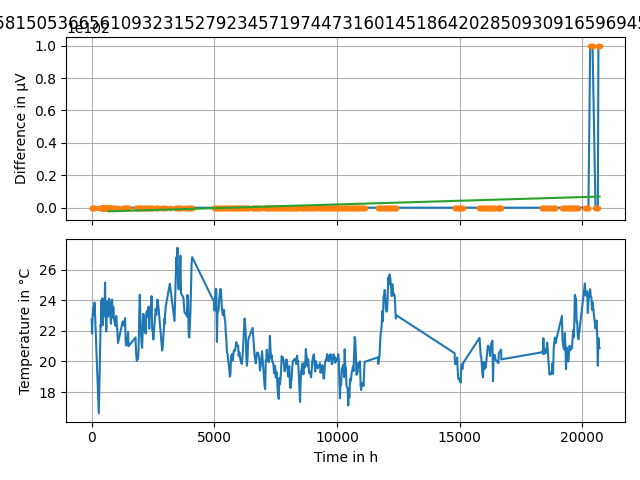

In [9]:
start=200
slope, intercept, rvalue, pvalue, stderr = stats.linregress(ts[start:], values[start:])


fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("Fluke 732C vs. M69 ({0:0.2f} ppm/year)".format(slope*3600*24*365 / 10))

#ax[0].errorbar(times, values, yerr=stds, capsize=5)
ax[0].plot(ts/3600, values)
ax[0].plot(ts/3600, values, '.')
ax[0].plot(ts[start:]/3600, ts[start:]*slope + intercept)
ax[0].set_ylabel("Difference in µV")
ax[0].grid()

ax[1].plot(ts/3600, temperature)
ax[1].set_ylabel("Temperature in °C")
#ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax[1].grid()
ax[1].set_xlabel("Time in h")


#fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("M69_ltd.png", dpi=150)

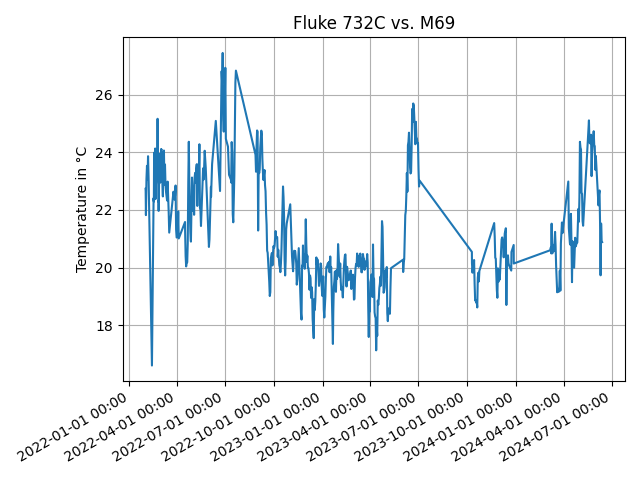

In [10]:
fig, ax = plt.subplots(1, 1)
plt.title("Fluke 732C vs. M69")
ax.plot(times, temperature)
plt.ylabel("Temperature in °C")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()
plt.tight_layout()
plt.grid()

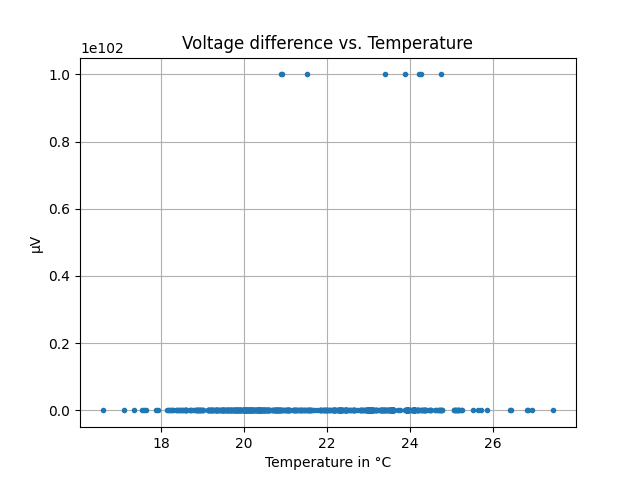

In [11]:
plt.figure()
plt.title("Voltage difference vs. Temperature")
plt.plot(temperature, values, '.')
plt.ylabel("µV")
plt.xlabel("Temperature in °C")
plt.grid()

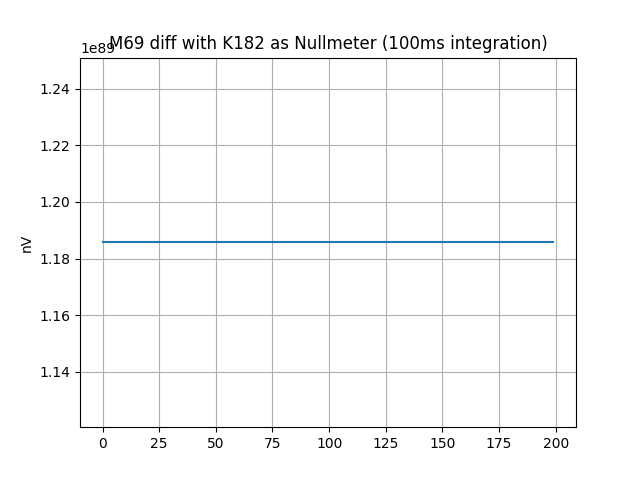

In [12]:
plt.figure()
plt.title("M69 diff with K182 as Nullmeter (100ms integration)")
plt.plot( (data["diff"] - np.mean(data["diff"]) ) * 1e9 )
plt.ylabel("nV")
plt.grid()

In [13]:
np.std(data["diff"] * 1e9)

0.0

In [14]:
otimes  = []
ovalues = []
ostds   = []
otemperature = []


for filename in sorted(glob.glob("data/*_offset.xlsx")):
    print(filename, end = "\r")
    data = pd.read_excel(filename)
    
    otimes.append(np.mean(data["timestamp"]))
    ovalues.append(np.mean(data["diff"]*1e9))
    ostds.append( 2 * np.std(data["diff"]*1e6)/len(data["diff"])**0.5  )
    #stds.append( np.std(data["diff"]*1e6) )
    otemperature.append(np.mean(data["temp"]))


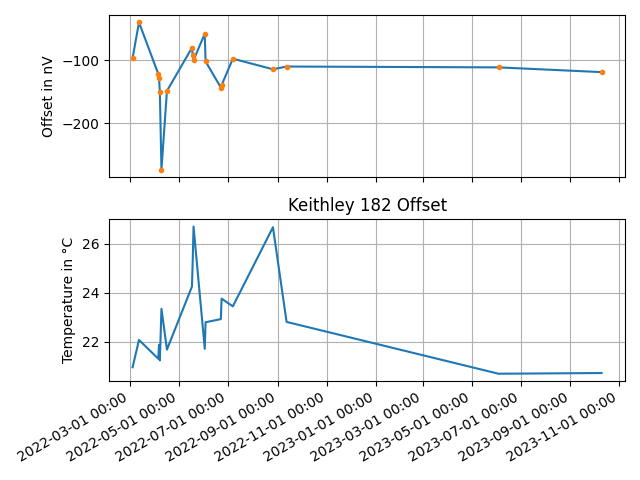

In [15]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.title("Keithley 182 Offset")

#ax[0].errorbar(times, values, yerr=stds, capsize=5)
ax[0].plot(otimes, ovalues)
ax[0].plot(otimes, ovalues, '.')
ax[0].set_ylabel("Offset in nV")
ax[0].grid()

ax[1].plot(otimes, otemperature)
ax[1].set_ylabel("Temperature in °C")
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax[1].grid()


fig.autofmt_xdate()
plt.tight_layout()

In [16]:
M69 = F732C + values[-1]*1e-6
M69

9.999998999999999e+95

In [17]:
(M69 - 10)/10 * 1e6

9.999999e+100

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


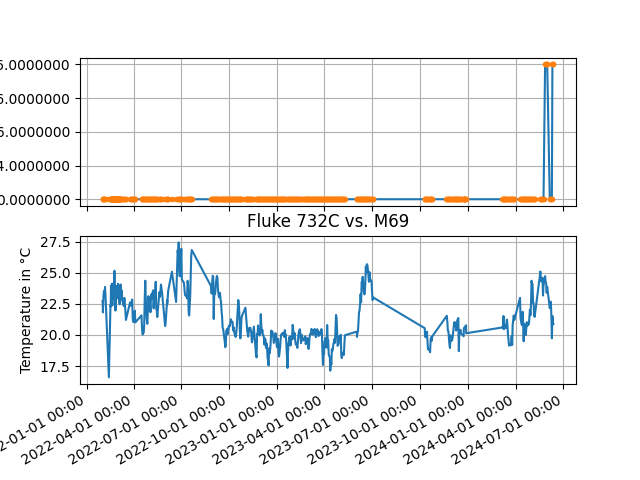

In [18]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.title("Fluke 732C vs. M69")

#ax[0].errorbar(times, values, yerr=stds, capsize=5)
ax[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: "{:0.7f}".format(x) ))
ax[0].plot(times, F732C+values*1e-6)
ax[0].plot(times, F732C+values*1e-6, '.')
ax[0].set_ylabel("M69 in V")
ax[0].grid()

ax[1].plot(times, temperature)
ax[1].set_ylabel("Temperature in °C")
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax[1].grid()


fig.autofmt_xdate()
plt.tight_layout()

In [19]:
np.mean(values[-92:-10])

3.658536219512195e+100